# CS4305TU - Assignment 2 - Regression

In this assignment, you will apply your newly obtained regression techniques with real-life data. **You should work in groups for this assignment.**

## Data source

What you will be playing with is aircraft trajectory data derived from [ADS-B](https://www.skybrary.aero/index.php/Automatic_Dependent_Surveillance_Broadcast_(ADS-B)). It is collected using the antenna from the top of the aerospace building:

<img src="https://pbs.twimg.com/media/EoBz7vVXEAAze48?format=jpg&name=medium" width="400"/>

Ensentially, ADS-B data is what you see on website like FlightRadar24:

<img src="https://media.giphy.com/media/cPutGcE0a9jdS/giphy.gif" width="400"/>

## Background

In the dataset, all flight trajectories include only the descent part of the flight. The dataset is split into two directories. One directory contains flights that are following the [Continous Descent Approach (CDA)](https://www.skybrary.aero/index.php/Continuous_Descent). The other directory contains flights that do not follow CDA. 

CDA is an operation, where the aircraft does not have any level flight segment during the descent. Follow the link above to know more.

<img src="https://1.bp.blogspot.com/-UFmjVcjmqCM/UIai54Y_wYI/AAAAAAAAAUM/tW1HTFP1IGI/s1600/image02_05_large.gif" width="400">


## Data attributes

The structures of all CSV files are the same. Here are descriptions of all columns:

- **time**: flight time in seconds, the first row starts at time 0.
- **icao**: aircraft transponder address, string format, unique for each aircraft.
- **type**: aircraft type code, string format.
- **callsign**: string format, often related to the flight number, unique for each flight.
- **latitude**: latitude coordinate in degrees.
- **longitude**: latitude coordinate  in degrees.
- **speed**: aircraft speed respective to ground, unit is in knots (1 knot = 0.51444 m/s).
- **track_angle**: direction of aircraft in relation to the true north, in degrees.
- **vertical_rate**: aircraft climb or descent speed in feet/minute (1 ft/min = 000508 m/s), negative value indicates aircraft is descending.

The most important features we are using are **time**, **altitude**, **speed**, and **vertical_rate**. 

## Instructions

The code in this notebook serves as the base for your assignment. The tasks are defined in each section.

You should implement the solutions using code cells and write your analysis using markdown cells.

Once you have complete everything, before submission, remember to restart the kernel and run all cells again. Make sure there are no errors. Then you should:

 - Save the notebook (**replace XX in the filename with your group number**)
 - Export a HTML version of the notebook. Hint: follow Mene -> File -> Download as -> HTML
 - Submit both the notebook (.ipynb) and the export (.html)


 ## References

- Quick tutorial for **Jupyter Notebook** : https://www.youtube.com/watch?v=2eCHD6f_phE

- Quick tutorial for **Jupyter Lab** (if you wish to use): https://www.youtube.com/watch?v=A5YyoCKxEOU
 

In [14]:
import glob
import warnings
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
import pymc3 as pm
warnings.filterwarnings("ignore")

In [2]:
# loading all trajectory files

cda_files = sorted(glob.glob("data/data/cda/*.csv"))
noncda_files = sorted(glob.glob("data/data/noncda/*.csv"))

## Examples

Following two cells are some examples for data and plotting.

Remove these before submit your assignment.

In [3]:
df_example = pd.read_csv(cda_files[0])
df_example.head(10)

,time,icao,type,callsign,latitude,longitude,altitude,speed,track_angle,vertical_rate
0,0.0,40631F,A319,EZY58YF,52.79041,2.55135,24975,445,101,-192
1,20.0,40631F,A319,EZY58YF,52.78042,2.61632,24625,441,106,-1408
2,40.0,40631F,A319,EZY58YF,52.76827,2.68098,23925,436,107,-2304
3,60.0,40631F,A319,EZY58YF,52.75611,2.74282,23225,432,107,-1984
4,80.0,40631F,A319,EZY58YF,52.74248,2.81368,22550,425,107,-1728
5,100.0,40631F,A319,EZY58YF,52.73261,2.86673,22000,420,106,-2112
6,140.0,40631F,A319,EZY58YF,52.70906,2.99515,20550,411,106,-2112
7,160.0,40631F,A319,EZY58YF,52.69504,3.07138,19900,400,106,-1344
8,180.0,40631F,A319,EZY58YF,52.68875,3.10529,19550,397,106,-2304
9,200.0,40631F,A319,EZY58YF,52.67740,3.16626,18775,396,107,-1664


<IPython.core.display.Javascript object>


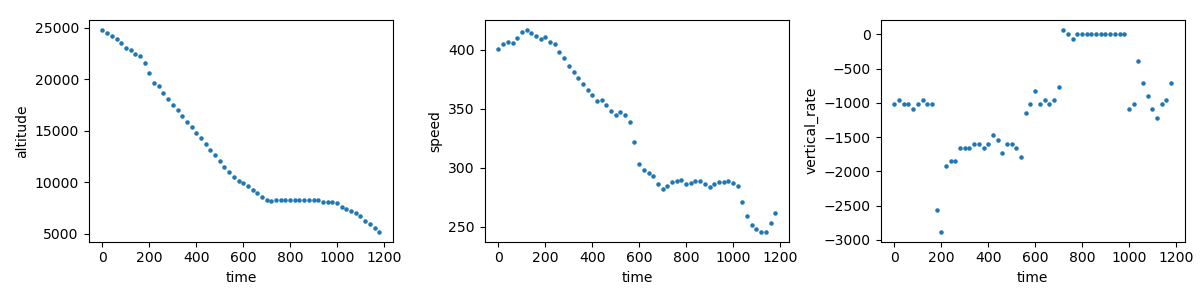

In [4]:
# visualization example

flight_sample = pd.read_csv(noncda_files[0])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(flight_sample.time, flight_sample.altitude, s=5)
ax[0].set_xlabel("time")
ax[0].set_ylabel("altitude")
ax[1].scatter(flight_sample.time, flight_sample.speed, s=5)
ax[1].set_xlabel("time")
ax[1].set_ylabel("speed")
ax[2].scatter(flight_sample.time, flight_sample.vertical_rate, s=5)
ax[2].set_xlabel("time")
ax[2].set_ylabel("vertical_rate")
plt.tight_layout()
plt.show()

# Task 1: Simple linear regression 

In this task you will learn how to apply simple linear regression model using a couple of flight trajectories. To complete the task, follow the steps below:

1. Use you group id as random seed, select one flight from CDA trajectories, and another one from Non-CDA trajectories

1. Inspect the relationships of (time, altitude), (time, speed), and (time, vertical_rate) for these two trajectories.

1. Apply linear regression to all three parameters for both trajectories, using time as input and altitude as output.

1. Evaluate the performance of the estimators using different error metrics.

In [5]:
# set group_id to your own group number

group_id = 19

In [6]:
np.random.seed(group_id)

cda_filename = np.random.choice(cda_files)
print(cda_filename)
noncda_filename = np.random.choice(noncda_files)

df_cda = pd.read_csv(cda_filename)
df_noncda = pd.read_csv(noncda_filename)

type_cda = df_cda["type"].iloc[0]
type_noncda = df_noncda["type"].iloc[0]


data/data/cda/93ce2914.csv


cda data representation


<IPython.core.display.Javascript object>


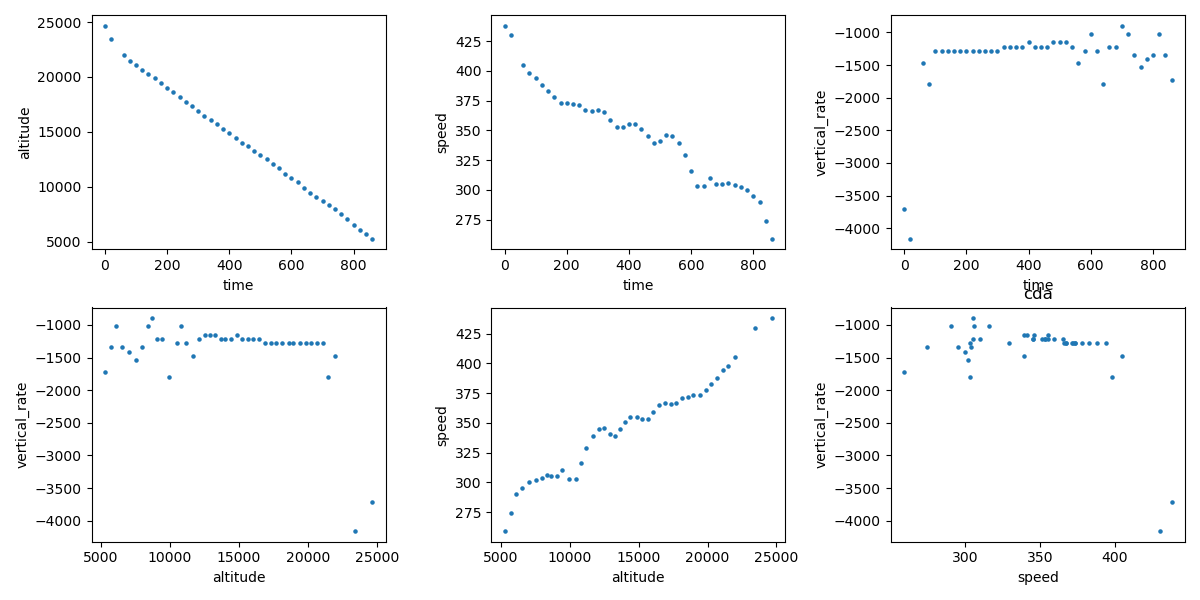

non-cda data representation


<IPython.core.display.Javascript object>


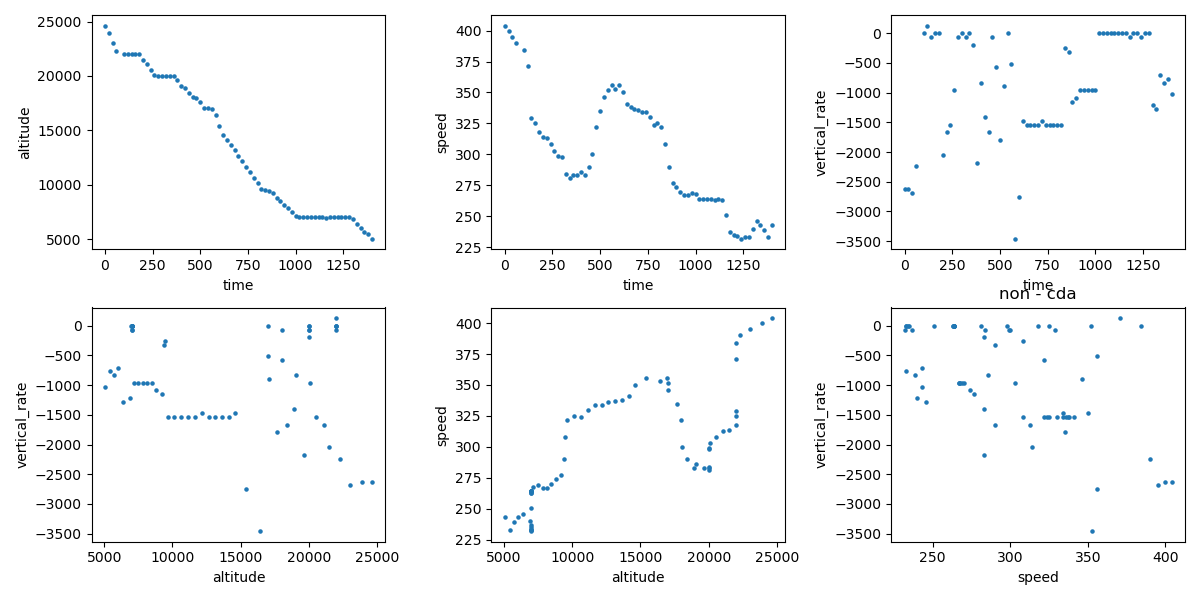

In [7]:
# write your code here

# create more cells if needed
print('cda data representation')
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].scatter(df_cda.time, df_cda.altitude, s=5)
ax[0,0].set_xlabel("time")
ax[0,0].set_ylabel("altitude")
ax[0,1].scatter(df_cda.time, df_cda.speed, s=5)
ax[0,1].set_xlabel("time")
ax[0,1].set_ylabel("speed")
ax[0,2].scatter(df_cda.time, df_cda.vertical_rate, s=5)
ax[0,2].set_xlabel("time")
ax[0,2].set_ylabel("vertical_rate")
ax[1,0].scatter(df_cda.altitude, df_cda.vertical_rate, s=5)
ax[1,0].set_xlabel("altitude")
ax[1,0].set_ylabel("vertical_rate")
ax[1,1].scatter(df_cda.altitude, df_cda.speed, s=5)
ax[1,1].set_xlabel("altitude")
ax[1,1].set_ylabel("speed")
ax[1,2].scatter(df_cda.speed, df_cda.vertical_rate, s=5)
ax[1,2].set_xlabel("speed")
ax[1,2].set_ylabel("vertical_rate")
plt.tight_layout()
plt.title('cda')
plt.show()

print('non-cda data representation')
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].scatter(df_noncda.time, df_noncda.altitude, s=5)
ax[0,0].set_xlabel("time")
ax[0,0].set_ylabel("altitude")
ax[0,1].scatter(df_noncda.time, df_noncda.speed, s=5)
ax[0,1].set_xlabel("time")
ax[0,1].set_ylabel("speed")
ax[0,2].scatter(df_noncda.time, df_noncda.vertical_rate, s=5)
ax[0,2].set_xlabel("time")
ax[0,2].set_ylabel("vertical_rate")
ax[1,0].scatter(df_noncda.altitude, df_noncda.vertical_rate, s=5)
ax[1,0].set_xlabel("altitude")
ax[1,0].set_ylabel("vertical_rate")
ax[1,1].scatter(df_noncda.altitude, df_noncda.speed, s=5)
ax[1,1].set_xlabel("altitude")
ax[1,1].set_ylabel("speed")
ax[1,2].scatter(df_noncda.speed, df_noncda.vertical_rate, s=5)
ax[1,2].set_xlabel("speed")
ax[1,2].set_ylabel("vertical_rate")
plt.tight_layout()
plt.title('non - cda')
plt.show()


In [8]:
## Linear regression
from sklearn.linear_model import LinearRegression
# for cda
x_train = df_cda.time.to_numpy
x_train = x_train()
y_train = df_cda.altitude.to_numpy
y_train = y_train()
lin_regress = LinearRegression().fit(x_train.reshape(-1,1), y_train)
print('intercept : ', lin_regress.intercept_)
print('slope : ', lin_regress.coef_[0])

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_train, lin_regress.predict(x_train.reshape(-1,1)))
print('MSE : ', MSE)
print('RMSE : ', np.sqrt(MSE))

intercept :  23351.76640518252
slope :  -21.009054842311887
MSE :  59504.539276738404
RMSE :  243.93552278571156


In [9]:
# for non - cda
x_train = df_noncda.time.to_numpy
x_train = x_train()
y_train = df_noncda.altitude.to_numpy
y_train = y_train()
lin_regress = LinearRegression().fit(x_train.reshape(-1,1), y_train)
print('intercept : ', lin_regress.intercept_)
print('slope : ', lin_regress.coef_[0])
MSE = mean_squared_error(y_train, lin_regress.predict(x_train.reshape(-1,1)))
print('MSE : ', MSE)
print('RMSE : ', np.sqrt(MSE))

intercept :  23948.393485141656
slope :  -14.789148407092222
MSE :  1622899.4684553042
RMSE :  1273.93071572017


(this is a markdown cell)

write your analysis here

- For cda
- - Altitude vs time plot shows a line with an almost constant slope (signifying constant descent). 
- - The variation in the speed is gradual. 
- - The vertical rate is negative and is almost constant (except at the end). 


- For non - cda
- - Altitude vs time plot shows a line with varying slope. 
- - Lot of variation in the speed. 
- - The vertical rate is negative and varying. 



# Task 2: Multiple linear regression

In this task you will learn how to apply Polynomial regression model. To complete the task, follow the steps below:

1. Using the same trajectories from the previous task, but choose both speed and altitude as predictors for the vertical rate. 

1. Construct a 3D multiple linear regression model

1. Visualize your result and briefly analyze your results.

Coefficients -3645.955578229411 -0.07127946954407556 9.765894118769795


<IPython.core.display.Javascript object>


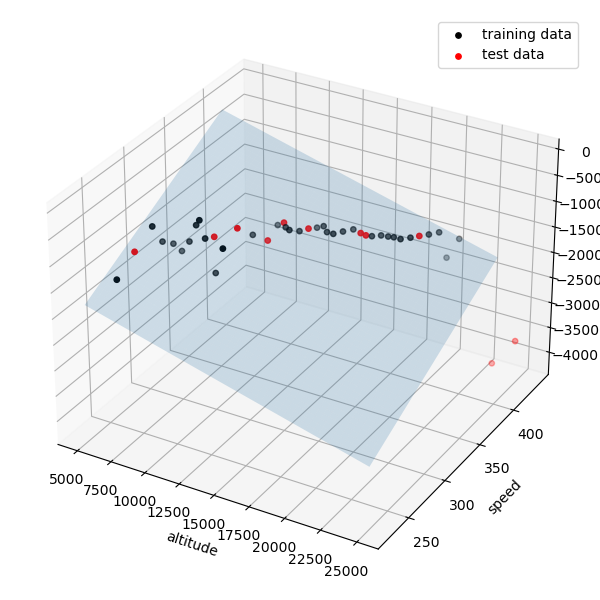

In [10]:
# write your code here

# create more cells if needed
from sklearn.model_selection import train_test_split

# for cda

x1 = df_cda.altitude.to_numpy
x1 = x1()
x2 = df_cda.speed.to_numpy
x2 = x2()
y = df_cda.vertical_rate.to_numpy
y = y()

x = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)), axis = 1)


x_train, x_test, y_train, y_test = train_test_split(x, y)

model = LinearRegression().fit(x_train, y_train)
b0 = model.intercept_
b1, b2 = model.coef_

print('Coefficients {} {} {}'.format(b0,b1,b2))


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, color = 'k', s = 15, label = 'training data')
ax.scatter(x_test[:,0], x_test[:,1], y_test, color = 'r', s = 15, label = 'test data')
ax.set_xlabel('altitude')
ax.set_ylabel('speed')
ax.set_zlabel('vertical rate')
ax.legend()


x1, x2 = np.meshgrid(range(5000, 25000), range(225, 400))
z = b0 + b1*x1 + b2*x2

ax.plot_surface(x1, x2, z, alpha = 0.2)
plt.tight_layout()

In [11]:
# for non - cda

x1 = df_noncda.altitude.to_numpy
x1 = x1()
x2 = df_noncda.speed.to_numpy
x2 = x2()
y = df_noncda.vertical_rate.to_numpy
y = y()

x = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)), axis = 1)


x_train, x_test, y_train, y_test = train_test_split(x, y)

model = LinearRegression().fit(x_train, y_train)
b0 = model.intercept_
b1, b2 = model.coef_

print('Coefficients {} {} {}'.format(b0,b1,b2))


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, color = 'k', s = 15, label = 'training data')
ax.scatter(x_test[:,0], x_test[:,1], y_test, color = 'r', s = 15, label = 'test data')
ax.set_xlabel('altitude')
ax.set_ylabel('speed')
ax.set_zlabel('vertical rate')
ax.legend()


x1, x2 = np.meshgrid(range(5000, 25000), range(225, 400))
z = b0 + b1*x1 + b2*x2

ax.plot_surface(x1, x2, z, alpha = 0.2)
plt.tight_layout()

Coefficients 2421.3765536511587 0.018749947637588322 -12.010902122528327


<IPython.core.display.Javascript object>

(this is a markdown cell)

write your analysis here






# Task 3: Polynomial regression

In this task you will learn how to apply Polynomial regression model. To complete the task, follow the steps below:

1. Based on previous trajectories, apply polynomial regression, using altitude as input and speed as output. 

1. Try out different orders of polynomials.

1. Analyze your choice briefly. Taking into consideration of bias-variance trade-off.

1. Applying regularization to a high-order polynomial model you have tried earlier. Write a brief analysis of your result.


In [ ]:
# write your code here

# create more cells if needed




(this is a markdown cell)

write your analysis here






# Task 4: Logistic regression

In this task you will learn how to apply Logistic regression model. You need to generate a new dataset based on given data. To complete the task, follow the steps below:

1. For all trajectories in CDA and NON-CDA group, apply linear regression, using time as input and altitude as output.

1. Calculate MAE for all regression models. Construct a dataset with MAE as input, and CDA status as output (CDA as 0, and NON-CDA as 1).

1. Determine the Logistic regression model describe the relationship between MAE and CDA status

In [ ]:
# write your code here

# create more cells if needed


def calcMAE(df):
    # complete this function for calculating MAE

    # [TODO] fit linear model to time and altitude

    # [TODO] calculate MAE

    return MAE


new_data = []

for f in cda_files:
    df = pd.read_csv(f)
    MAE = calcMAE(df)
    new_data.append((MAE, 0))

for f in noncda_files:
    df = pd.read_csv(f)

    MAE = calcMAE(df)
    new_data.append((MAE, 1))

In [ ]:
# write your logistic regression code here

(this is a markdown cell)

write your analysis here






# Task 5: Bayesian regression

In this task you will learn how to apply Bayesian regression model. I recommend to use of `pymc3` library. To complete the task, follow the steps below:

1. Apply Bayesian linear regression to vertical speed of CDA and Non-CDA trajectories (time as input). Provide an analysis of your result.

1. **(Bonus)** Design a quadratic model to altitude using the Bayesian regression approach. Visualize and analyze your findings.



In [21]:
# write your code here

# create more cells if needed

# Tip: try different prior probability density functions of parameters. If the regression fails:
#   1. change the initial guess.
#   2. change the variance for the priors of the random variables


## for cda

x1 = df_cda.altitude.to_numpy
x1 = x1()
x2 = df_cda.speed.to_numpy
x2 = x2()
y = df_cda.vertical_rate.to_numpy
y = y()

x = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)), axis = 1)


x_train, x_test, y_train, y_test = train_test_split(x1, y)

with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=0, sd=20)
    beta_1 = pm.Normal("beta_1", mu=0, sd=20)
    sigma = pm.HalfNormal("sigma", sd=30)

    y = pm.Normal("y", mu=beta_0 + beta_1 * x_train, sd=sigma, observed=y_train.reshape(-1,1))

    # using the simplest MH sampler
    step = pm.Metropolis()
    
    # we are drawing 5000 samples using 4 chains
    trace = pm.sample(draws=5000, step=step, chains=4)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_1]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>


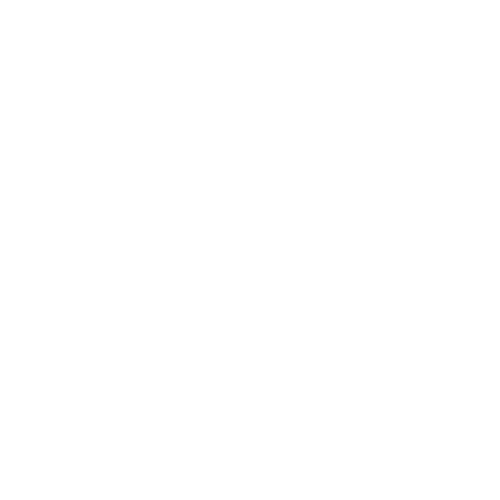

<IPython.core.display.Javascript object>


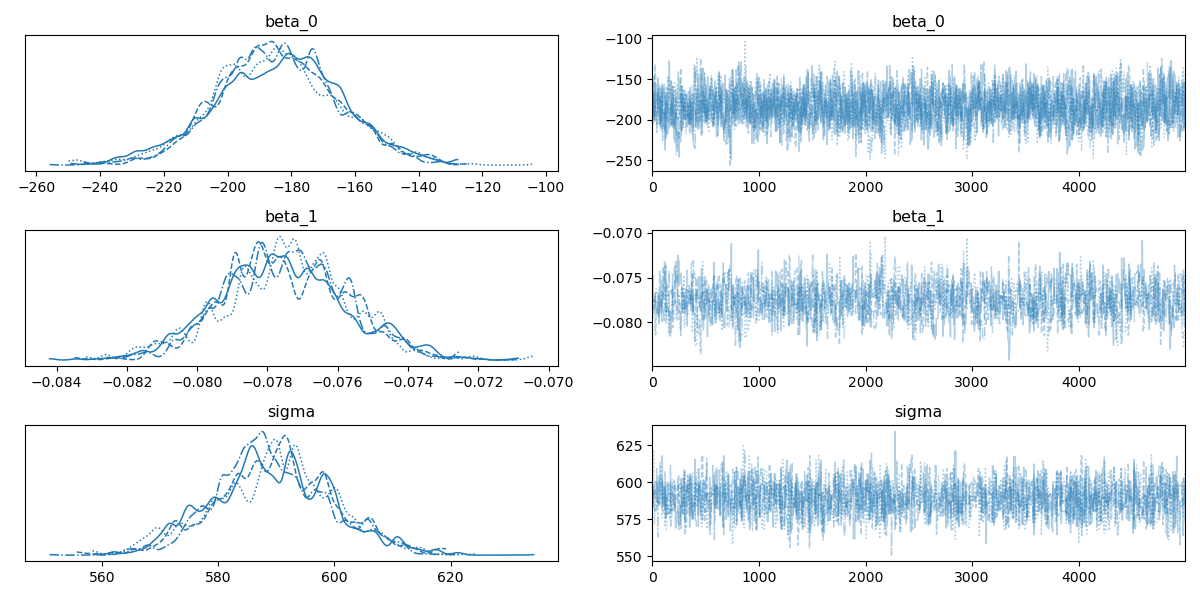

In [28]:
plt.figure(figsize=(5, 5))
pm.traceplot(trace)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


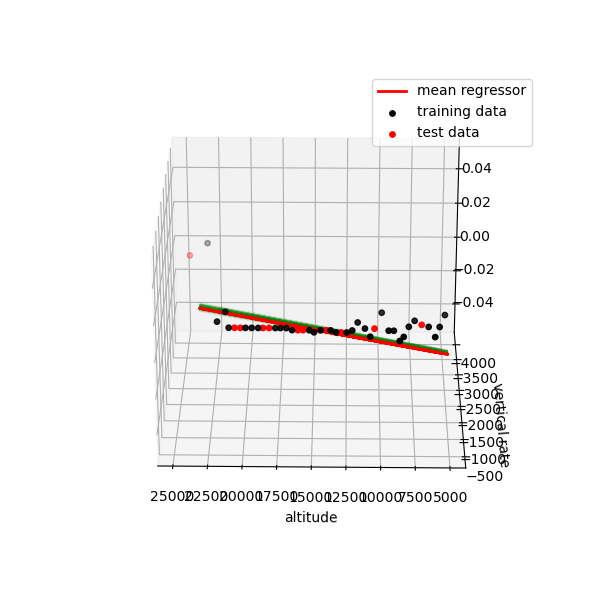

In [27]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x_train,  y_train, color = 'k', s = 15, label = 'training data')
ax.scatter(x_test, y_test, color = 'r', s = 15, label = 'test data')
ax.set_xlabel('altitude')
ax.set_ylabel('vertical rate')
ax.legend()

for i in range(100):
    b0 = np.random.choice(trace["beta_0"])
    b1 = np.random.choice(trace["beta_1"])
    ax.plot(x_train, b0 + i + b1 * x_train, lw=0.5, color="g", alpha=0.1)

b0 = trace["beta_0"].mean()
b1 = trace["beta_1"].mean()
ax.plot(x_train, b0 + i + b1 * x_train, lw=2, color="r", label="mean regressor")

plt.legend()

plt.show()

In [29]:
## for non-cda

x1 = df_noncda.altitude.to_numpy
x1 = x1()
x2 = df_noncda.speed.to_numpy
x2 = x2()
y = df_noncda.vertical_rate.to_numpy
y = y()

x = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)), axis = 1)


x_train, x_test, y_train, y_test = train_test_split(x1, y)

with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=0, sd=20)
    beta_1 = pm.Normal("beta_1", mu=0, sd=20)
    sigma = pm.HalfNormal("sigma", sd=30)

    y = pm.Normal("y", mu=beta_0 + beta_1 * x_train, sd=sigma, observed=y_train.reshape(-1,1))

    # using the simplest MH sampler
    step = pm.Metropolis()
    
    # we are drawing 5000 samples using 4 chains
    trace = pm.sample(draws=5000, step=step, chains=4)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_1]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>


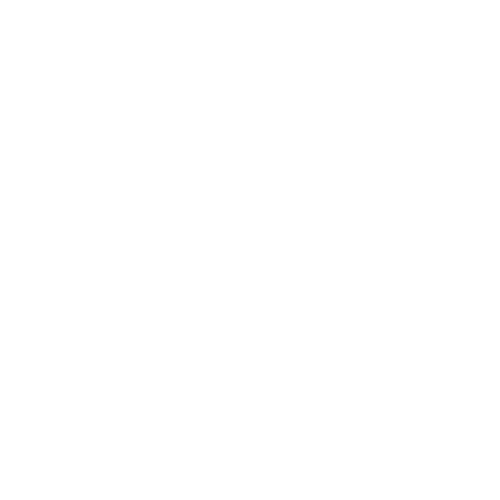

<IPython.core.display.Javascript object>


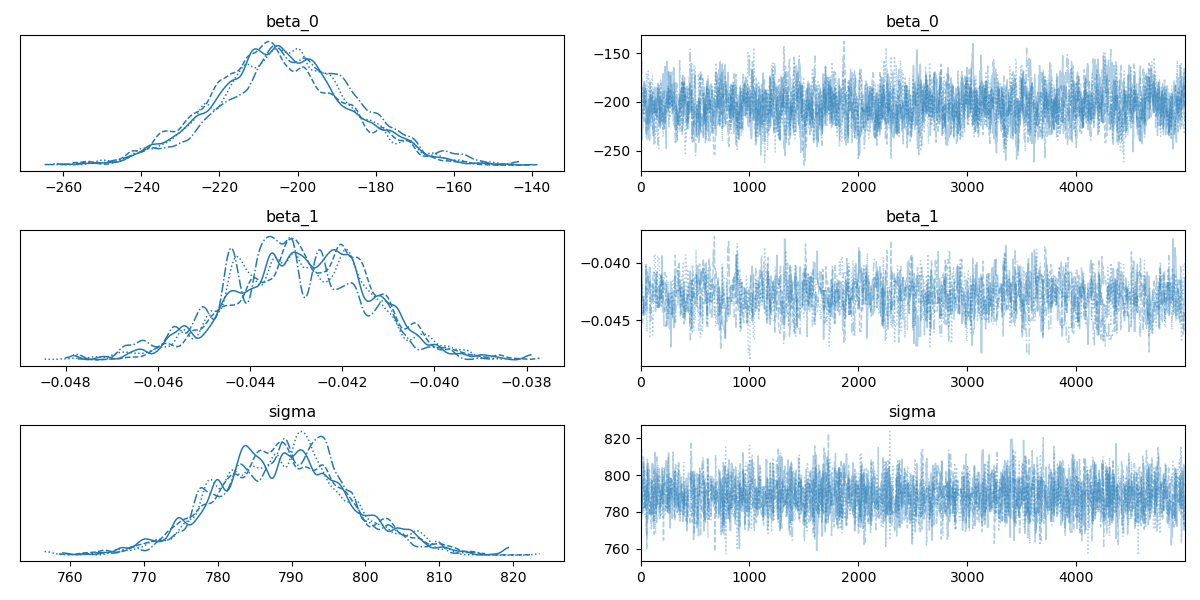

In [30]:
plt.figure(figsize=(5, 5))
pm.traceplot(trace)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


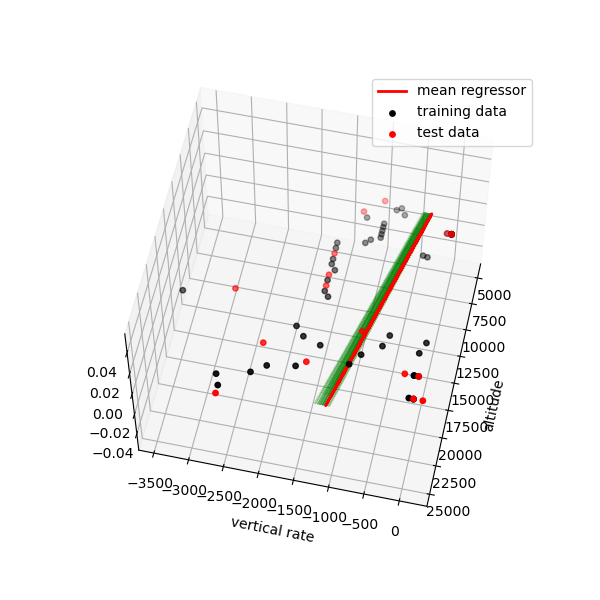

In [31]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x_train,  y_train, color = 'k', s = 15, label = 'training data')
ax.scatter(x_test, y_test, color = 'r', s = 15, label = 'test data')
ax.set_xlabel('altitude')
ax.set_ylabel('vertical rate')
ax.legend()

for i in range(100):
    b0 = np.random.choice(trace["beta_0"])
    b1 = np.random.choice(trace["beta_1"])
    ax.plot(x_train, b0 + i + b1 * x_train, lw=0.5, color="g", alpha=0.1)

b0 = trace["beta_0"].mean()
b1 = trace["beta_1"].mean()
ax.plot(x_train, b0 + i + b1 * x_train, lw=2, color="r", label="mean regressor")

plt.legend()

plt.show()

(this is a markdown cell)

write your analysis here




